In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta
import datetime as dt
import heapq 

In [3]:
import numpy as np
sigma = 0
for i in range(1, 2026):
    sigma += i**2 * (((1+np.sqrt(5))/2)**i - ((1-np.sqrt(5))/2)**i)
print(sigma)

inf


C:\Users\hollanderj\AppData\Local\Temp\ipykernel_5368\3189171147.py:4: RuntimeWarning: overflow encountered in scalar add
  sigma += i**2 * (((1+np.sqrt(5))/2)**i - ((1-np.sqrt(5))/2)**i)
C:\Users\hollanderj\AppData\Local\Temp\ipykernel_5368\3189171147.py:4: RuntimeWarning: overflow encountered in scalar multiply
  sigma += i**2 * (((1+np.sqrt(5))/2)**i - ((1-np.sqrt(5))/2)**i)
C:\Users\hollanderj\AppData\Local\Temp\ipykernel_5368\3189171147.py:4: RuntimeWarning: overflow encountered in scalar power
  sigma += i**2 * (((1+np.sqrt(5))/2)**i - ((1-np.sqrt(5))/2)**i)


In [2]:
# loading data
path = r"Data\CVX_options.csv"
options_df = pd.read_csv(path)

In [3]:
# standardizing column naming 
options_df.columns = [x.lower().replace(" ", "_") for x in options_df.columns]

In [4]:
# dropping rows with impossible prices
mask1 = options_df["bid_price"] > 0
mask2 = options_df["ask_price"] > 0
mask3 = options_df["bid_size"] > 0
mask4 = options_df["ask_size"] > 0

options_df = options_df[mask1 | mask2 | mask3 | mask4]

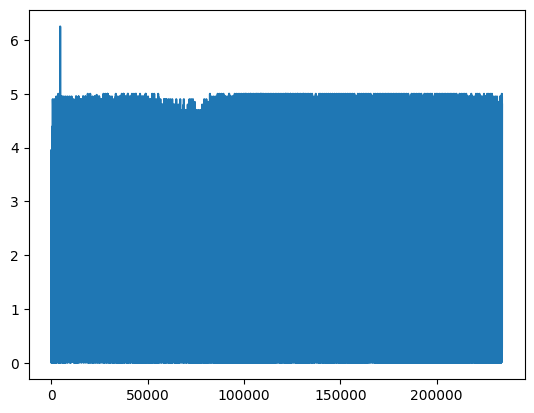

In [5]:
# creating mid price
plt.plot(options_df["ask_price"] - options_df["bid_price"], label="Spread")
#options_df.loc[:, "mid_price"] = round((options_df["ask_price"] + options_df["bid_price"])/2, 5)

(array([1.44522e+05, 1.81410e+04, 1.26430e+04, 1.34240e+04, 1.21680e+04,
        1.30930e+04, 1.08470e+04, 9.03300e+03, 0.00000e+00, 1.00000e+00]),
 array([0.01 , 0.634, 1.258, 1.882, 2.506, 3.13 , 3.754, 4.378, 5.002,
        5.626, 6.25 ]),
 <BarContainer object of 10 artists>)

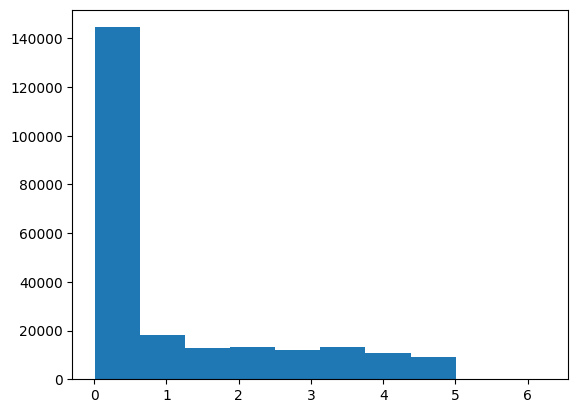

In [6]:
plt.hist(options_df["ask_price"] - options_df["bid_price"])

In [7]:
# concatenating call and put rows for the same price    
# call mid, put mid are columns 16 and 17 respectively
options_df["call_mid"] = 0
options_df["put_mid"] = 0
options_df["call_open_interest"] = 0
options_df["put_open_interest"] = 0
options_df["call_volume"] = 0
options_df["put_volume"] = 0
    
# boolean masks for call and put options in every second row
call_mask = (options_df.iloc[::2, 2] == "call").values
put_mask = (options_df.iloc[::2, 2] == "put").values

# indices of every second row
indices = np.arange(0, options_df.shape[0], 2)

# assign values based on call options
# if call, call mid will be assigned from mid price and put mid will be assigned from next mid price same with open interest
options_df.iloc[indices[call_mask], 16] = options_df.iloc[indices[call_mask], 15].values
options_df.iloc[indices[call_mask], 17] = options_df.iloc[indices[call_mask] + 1, 15].values
# assign values based on put options
options_df.iloc[indices[put_mask], 17] = options_df.iloc[indices[put_mask], 15].values
options_df.iloc[indices[put_mask], 16] = options_df.iloc[indices[put_mask] + 1, 15].values
# open interest
options_df.iloc[indices[call_mask], 18] = options_df.iloc[indices[call_mask], 10].values
options_df.iloc[indices[call_mask], 19] = options_df.iloc[indices[call_mask] + 1, 10].values

options_df.iloc[indices[put_mask], 19] = options_df.iloc[indices[put_mask], 10].values
options_df.iloc[indices[put_mask], 18] = options_df.iloc[indices[put_mask] + 1, 10].values
#volume
options_df.iloc[indices[call_mask], 20] = options_df.iloc[indices[call_mask], 9].values
options_df.iloc[indices[call_mask], 21] = options_df.iloc[indices[call_mask] + 1, 9].values

options_df.iloc[indices[put_mask], 21] = options_df.iloc[indices[put_mask], 9].values
options_df.iloc[indices[put_mask], 20] = options_
df.iloc[indices[put_mask] + 1, 9].values

IndexError: iloc cannot enlarge its target object

In [6]:
# reducing rows to every other and fixing index
options_df = options_df[options_df.index % 2 == 0]
options_df.index = np.arange(0, len(options_df))

In [7]:
# combining open interest and volume
options_df["combined_oi"] = options_df["call_open_interest"] + options_df["put_open_interest"]
options_df["combined_volume"] = options_df["call_volume"] + options_df["put_volume"]

In [8]:
# creating DTE
T = (pd.to_datetime(options_df["expiration_date"]) - pd.to_datetime(options_df["date"])).dt.days
options_df["DTE"] = T

In [10]:
options_df.columns

Index(['date', 'expiration_date', 'type', 'strike_price', 'ask_price',
       'ask_size', 'bid_price', 'bid_size', 'last_price', 'volume',
       'open_interest', 'closing_price', 'exp_closing_price', 'date_div',
       'exp_date_div', 'mid_price', 'call_mid', 'put_mid',
       'call_open_interest', 'put_open_interest', 'call_volume', 'put_volume',
       'combined_oi', 'combined_volume', 'DTE'],
      dtype='object')

In [42]:
from scipy import optimize as opt
import scipy.stats as si


# defining implied vol function
def implied_vol(price, S, K, T, r=0.05):
    def bs_price(sigma):
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        est_price = S * si.norm.cdf(d1, 0, 1) - K * np.exp(-r * T) * si.norm.cdf(d2, 0, 1)
        return est_price - price
    def vega(sigma):
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        return S * np.sqrt(T) * si.norm.pdf(d1, 0, 1)
    
    #return opt.brentq(bs_price, 0.00001, 20, maxiter=1000)
    return opt.newton(bs_price, 0.3, maxiter=100)

row = options_df.iloc[10, :]
s = implied_vol(row["mid_price"], row["closing_price"], row["strike_price"], row["DTE"]/365)

RuntimeError: Tolerance of 15948.36990428351 reached. Failed to converge after 3 iterations, value is -2221.125793777974.

In [46]:
row = options_df.iloc[10, :]
S = row["closing_price"]
K = row["strike_price"]
r = 0.05
T = row["DTE"]/365
price = row["mid_price"]
sigma = 0.3

def bs_price(sigma):
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        est_price = S * si.norm.cdf(d1, 0, 1) - K * np.exp(-r * T) * si.norm.cdf(d2, 0, 1)
        return est_price - price 

d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
v = S * np.sqrt(T) * si.norm.pdf(d1, 0, 1)

C:\Users\hollanderj\AppData\Local\Temp\ipykernel_13508\1487816262.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


0.0

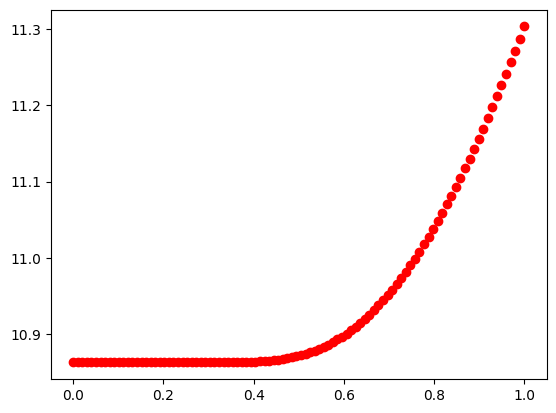

In [47]:
ff = np.linspace(0, 1, 100)
plt.plot(ff, y := [bs_price(x) for x in ff], 'ro')
ff[np.argmin(np.abs(y))]

In [51]:
row = options_df.iloc[10, :]
S = row["closing_price"]
K = row["strike_price"]
r = 0.05
T = row["DTE"]/365
price = row["mid_price"]
print(S, K, T, price)

88.85 78.0 0.010958904109589041 0.03


In [ ]:
# creating new dataframe for date organization
df = pd.DataFrame()

# organizing based on dates
for header in ["DTE", "strike price", "closing price", "call mid", "put mid", "call_open_interest", "put_open_interest", "combined_oi", "combined_volume"]:
    df[header] = options_df.groupby("date")[header].apply(np.array)

# converting index to date column
if "date" not in df.columns:
    df = df.reset_index()

df["date"] = pd.to_datetime(df["date"])
df["terms"] = df["DTE"].apply(lambda x: sorted(set(x)))
df.head(1)